# Improvement & Evaluation

## 0. Preparation

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVR,SVC
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVR,SVC
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import CCA
from sklearn.model_selection import cross_val_score
import statsmodels.api as sm
from sklearn.feature_extraction.text import  TfidfVectorizer, CountVectorizer

import re

### 0.1 Loading Datasets (tfidf)

In [2]:
def word_to_phrase(flist):
    plist = []
    if len(flist) > 0:
        for feature in flist:
            feature = re.sub('[_]',' ',feature)
            feature = feature.strip()
            feature_p = ''.join(feature.split(' '))
            plist.append(feature_p)
    return plist

def list_to_string(flist):
    string = ' '.join(flist)
    return string

In [3]:
ori_train = pd.read_json('train.json.zip', orient='columns', convert_dates=['created'], compression='zip')
ori_train = ori_train.reset_index()
ori_train.rename(columns={'index':'rec_id'}, inplace=True) 
train = ori_train
test =  pd.read_json('test.json.zip', orient='columns', convert_dates=['created'], compression='zip')
test = test.reset_index()
test.rename(columns={'index':'rec_id'}, inplace=True)

# remove outliers with ridiculously high prices
train = train[train['price']<=20000]
# remove outliers which the houses locate far away from most of the houses and missing values
train = train[(train['latitude'] <= 41.5) & (train['latitude'] >= 40) & (train['longitude'] >= -80) & (train['longitude'] <= -70)]
# remove outliers which have bathrooms more than bedrooms
train['diff_rooms'] = train['bedrooms'] - train['bathrooms']
train = train[train['diff_rooms']>=-1.5]

train_text = train[['description', 'features']]
test_text = test[['description', 'features']]
data_text = pd.concat([train_text, test_text], axis=0)

# tfidf
desc_tfidf = TfidfVectorizer(min_df=20, max_features=40, strip_accents='unicode',lowercase =True,
                        analyzer='word', token_pattern=r'\w{5,}', ngram_range=(1, 3),  sublinear_tf=True, stop_words = 'english')  
desc_tfidf_fit =desc_tfidf.fit_transform(data_text['description'])
desc_name = [x for x in desc_tfidf.get_feature_names()]
# standardize "feature"
data_text['features_phr'] = data_text['features'].apply(word_to_phrase)
data_text['features_phr_str'] = data_text['features_phr'].apply(list_to_string)
# tfidf 'feature'
phr_tfidf = TfidfVectorizer(min_df=2, max_features=40, strip_accents='unicode', lowercase=True, token_pattern=r'\w{3,}', stop_words='english')  
phr_tfidf_fit =phr_tfidf.fit_transform(data_text['features_phr_str'])
phr_names = [x for x in phr_tfidf.get_feature_names()]
data_text['features_phr_vec'] = pd.Series(phr_tfidf_fit.toarray().tolist())

In [4]:
phr_list = phr_tfidf_fit.toarray().tolist()
p_array=np.asarray(phr_list).reshape(123824, 40)
phr = pd.DataFrame(p_array, columns=["p_%d" % i for i in range(0, 40)])

desc_list = desc_tfidf_fit.toarray().tolist()
d_array=np.asarray(desc_list).reshape(123824, 40)
desc = pd.DataFrame(d_array, columns=["d_%d" % i for i in range(0, 40)])

In [5]:
text = phr.join([desc])
text

,p_0,p_1,p_2,p_3,p_4,p_5,p_6,p_7,p_8,p_9,...,d_30,d_31,d_32,d_33,d_34,d_35,d_36,d_37,d_38,d_39
0,0.0,0.269246,0.0,0.505923,0.288970,0.280043,0.000000,0.000000,0.0,0.0,...,0.000000,0.194602,0.228802,0.000000,0.000000,0.000000,0.000000,0.000000,0.131750,0.0
1,0.0,0.000000,0.0,0.000000,0.411748,0.000000,0.410219,0.360214,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.186830,0.0
2,0.0,0.000000,0.0,0.000000,0.383966,0.000000,0.382540,0.335909,0.0,0.0,...,0.182340,0.340825,0.000000,0.155577,0.161545,0.173477,0.159496,0.172502,0.109952,0.0
3,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.277344,0.299960,0.191192,0.0
4,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.474337,0.416516,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.382024,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123819,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
123820,0.0,0.335651,0.0,0.000000,0.360240,0.349111,0.358902,0.315153,0.0,0.0,...,0.245978,0.219085,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.148325,0.0
123821,0.0,0.693074,0.0,0.000000,0.000000,0.720867,0.000000,0.000000,0.0,0.0,...,0.000000,0.191186,0.224785,0.183148,0.190173,0.204220,0.187761,0.203073,0.000000,0.0
123822,0.0,0.493459,0.0,0.000000,0.000000,0.513247,0.527642,0.463324,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0


### 0.2 Drop correlated columns and less significant columns

In [6]:
def remove_correlated_features(X):
    corr_threshold = 0.9
    corr = X.corr()
    drop_columns = np.full(corr.shape[0], False, dtype=bool)
    for i in range(corr.shape[0]):
        for j in range(i + 1, corr.shape[0]):
            if corr.iloc[i, j] >= corr_threshold:
                drop_columns[j] = True
    columns_dropped = X.columns[drop_columns]
    X.drop(columns_dropped, axis=1, inplace=True)
    return columns_dropped

In [7]:
def remove_less_significant_features(X, Y):
    sl = 0.05
    regression_ols = None
    columns_dropped = np.array([])
    for itr in range(0, len(X.columns)):
        regression_ols = sm.OLS(Y, X).fit()
        max_col = regression_ols.pvalues.idxmax()
        max_val = regression_ols.pvalues.max()
        if max_val > sl:
            X.drop(max_col, axis='columns', inplace=True)
            columns_dropped = np.append(columns_dropped, [max_col])
        else:
            break
    regression_ols.summary()
    return columns_dropped

In [8]:
columns_dropped_corr = remove_correlated_features(text)

In [9]:
columns_dropped_corr

Index(['p_24', 'p_29', 'p_35', 'p_38', 'd_19', 'd_29', 'd_34', 'd_36', 'd_37'], dtype='object')

In [10]:
ori_train=pd.read_json("modified_data/modified_train.json")
ori_test = pd.read_json("modified_data/modified_test.json")

ori_train = ori_train.drop(columns=['rec_id', 'building_id','description','display_address','manager_id','features','photos','street_address','features_phr_vec','description_vec','text_vec'])
ori_train = ori_train.reset_index()
train = ori_train.join(text)

ori_test = ori_test.drop(columns=['rec_id', 'building_id','description','display_address','manager_id','features','photos','street_address','features_phr_vec','description_vec','text_vec'])
ori_test = ori_test.reset_index()
test = ori_test.join(text)

Listing_id_train = train['listing_id']
y_train = train['interest_level']
X_train = train.drop(columns=['index','listing_id', 'interest_level', 'diff_rooms'])

Listing_id_test = test['listing_id']
X_test = test.drop(columns=['index', 'listing_id'])

y_train_map = {"low":0, "medium": 1, "high": 2}
y_train = y_train.map(y_train_map)

In [11]:
X = pd.concat([X_train, X_test])

In [12]:
X_train = X[:49165]
X_test = X[49165:]

In [13]:
columns_dropped_insig = remove_less_significant_features(X_train, y_train)
X_sig = X.drop(columns=columns_dropped_insig)
columns_dropped_insig

c:\users\xixi6\appdata\local\programs\python\python38\lib\site-packages\pandas\core\frame.py:3987: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


array(['d_1', 'p_21', 'd_4', 'p_20', 'd_9', 'p_25', 'p_1', 'p_0', 'd_26',
       'd_5', 'd_10', 'd_27', 'd_15', 'd_2', 'created', 'd_11', 'd_33',
       'd_35', 'p_13', 'd_17', 'd_16', 'p_12', 'manager_id_num'],
      dtype='<U32')

### 0.3 Data Reduction - PCA & Scaler

In [13]:
# apply PCA
X_pca = PCA(n_components=6).fit_transform(X)
X_train_pca = X_pca[:49165]
X_test_pca = X_pca[49165:]

In [14]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_pca)
X_train_scaled = X_scaled[:49165]
X_test_scaled = X_scaled[49165:]

## 1. Cross-validation Functions

### 1.1 KFold

In [55]:
scores = []

In [56]:
from sklearn.svm import SVC
from sklearn.model_selection import KFold, cross_val_score
def crossValidation(clf, X, y, n):
    cv = KFold(n_splits=n)
    y_pred = []
    i=0
    # split the training data to training and validation data
    for train_index, valid_index in cv.split(X):
        print("loop %d" % i)
        i += 1
        X_tr, X_va, y_tr, y_va = X[train_index], X[valid_index], y.iloc[train_index], y.iloc[valid_index]
        clf.fit(X_tr, y_tr)
        y_pred.append(clf.predict(X_va))
        newScore = clf.score(X_va, y_va)
        scores.append(newScore)
    return y_pred
    

In [57]:
import time
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.multiclass import OneVsRestClassifier
n_estimators = 10
clf = OneVsRestClassifier(BaggingClassifier(SVC(kernel='sigmoid',C=1, gamma='auto', probability=True, class_weight='balanced'), max_samples=1.0/ n_estimators, n_estimators=n_estimators))

In [58]:
y_pred = crossValidation(clf, X_train_scaled, y_train, 5)

loop 0
loop 1
loop 2
loop 3
loop 4


In [61]:
scores_array = np.asarray(scores)

In [64]:
print("Accuracy: %0.6f (+/- %0.6f)" % (scores_array.mean(), scores_array.std() * 2))

Accuracy: 0.468606 (+/- 0.035354)


### 1.2 GridSearchCV

In [16]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedShuffleSplit
import time
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.multiclass import OneVsRestClassifier

def tuneParameters(X, y, tuned_parameters, X_test):
    score = 'accuracy'
    
    print('# Tuning hyper-parameters for %s' % score)
    print()
    n_estimators=10
    cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
    grid = GridSearchCV(SVC(probability=True, class_weight='balanced', cache_size=10000), param_grid=tuned_parameters,scoring='accuracy', cv=cv)
    
    grid.fit(X, y)

    print("Best parameters set found on development set:")
    print()
    print(grid.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = grid.cv_results_['mean_test_score']
    stds = grid.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, grid.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()


    return grid.predict_proba(X_test)

In [ ]:
tuned_parameters = [{'kernel': ['linear'], 'C': [1,100]}]

y_test = tuneParameters(X_train_scaled, y_train, tuned_parameters, X_test_scaled)

# Tuning hyper-parameters for accuracy



## 3 Further improvements

### 3.1 Bagging in SVC

In [27]:
import time
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.multiclass import OneVsRestClassifier

def bagging(X, y, X_test):
    n_estimators = 10
    start = time.time()
    clf = OneVsRestClassifier(BaggingClassifier(SVC(kernel='linear',C=10, probability=True, class_weight='balanced'), max_samples=1.0/ n_estimators, n_estimators=n_estimators))
    clf.fit(X, y)
    end = time.time()
    print("Bagging SVC:", end - start, clf.score(X,y))
    return clf.predict_proba(X_test)


#### Bagging here helps improve the efficiency 

#### Linear kernel with C=10

In [28]:
y_test = bagging(X_train_scaled, y_train, X_test_scaled, 'linear', 10)

Bagging SVC: 59.25253129005432 0.6937455506966338


In [29]:
# change the order of columns in result
y_test_df = pd.DataFrame(y_test)
cols = y_test_df.columns.tolist()
cols = cols[-1:] + cols[:-1]
y_test = y_test_df[cols].to_numpy()

In [30]:
def to_result_format(X):
    res = pd.DataFrame(y_test,columns=['high', 'low', 'medium'])
    temp = res['low']
    res = res.drop(columns = {'low'})
    res.insert(2,'low',temp)
    res.insert
    res.insert(0,'listing_id',X['listing_id'])
    res.to_csv('submission.csv', index = None)
    return res

In [31]:
X_test_df = pd.DataFrame(X_test).join([Listing_id_test])
res = to_result_format(X_test_df)

In [32]:
res

,listing_id,high,medium,low
0,7142618,0.081533,0.227132,0.691335
1,7210040,0.083058,0.226309,0.690633
2,7174566,0.082346,0.227387,0.690267
3,7191391,0.082670,0.226395,0.690935
4,7171695,0.082036,0.226435,0.691529
...,...,...,...,...
74654,6928108,0.077813,0.234572,0.687615
74655,6906674,0.076642,0.232124,0.691233
74656,6897967,0.077122,0.234780,0.688098
74657,6842183,0.075041,0.231113,0.693846


#### Logloss=0.79002

### Visualization of parameter tuning

In [65]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [66]:
def plotSVC(X, y, clfs, titles):
    # create a mesh to plot in
    x_min, x_max = X[:, 0].min() -1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    h = (x_max - x_min)/100
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),np.arange(y_min, y_max, h))
    for i, clf in enumerate(clfs):
        plt.subplot(2, 2, i + 1)
        #print(np.c_[xx.ravel(), yy.ravel()])
        Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)
        plt.contourf(xx, yy, Z, cmap=plt.cm.Paired, alpha=0.8)
        plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Paired)
        plt.xlabel('Sepal length')
        plt.ylabel('Sepal width')
        plt.xlim(xx.min(), xx.max())
        plt.ylim(yy.min(), yy.max())
        plt.xticks(())
        plt.yticks(())
        plt.title(titles[i])
        
    plt.show()

### Confusion Matrix

In [25]:
y_valid = y_train

In [45]:
y_p = np.asarray(y_pred).reshape(49165,1)

In [50]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
def cm_plot(y_valid,y_pred):
    cm = confusion_matrix(y_valid, y_pred, labels = [0,1,2])
    cm = pd.DataFrame(cm,columns=['low','medium','high'],index = ['low','medium','high'])
    plt.title('Confusion Matrix',fontsize=18)
    ax = sns.heatmap(cm,annot=True,cmap='YlGn_r',fmt='.20g',linewidths = 0)
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)
    plt.xlabel('Predicted Label',fontsize=12)
    plt.ylabel('True Label',fontsize=12)
    plt.savefig('cm.png',dpi=800)

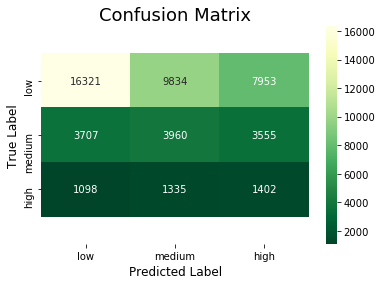

In [51]:
cm_plot(y_valid, y_p)